### TKOH Sample Code

In [68]:
# dependencies
import pandas as pd
import json
import math

In [69]:
# load beacon data
raw_data = pd.read_csv('survey/0621/beacon.csv')
raw_data.columns = ['gateway', 'rssi', 'ts', 'raw_ble']
raw_data

,gateway,rssi,ts,raw_ble
0,BL-43,-86,1.655801e+09,043E2A02010001C0BBC40423ED1E0201061AFF4C000215...
1,BL-42,-82,1.655801e+09,043E2A02010001C0BBC40423ED1E0201061AFF4C000215...
2,BL-43,-88,1.655801e+09,043E2A02010001C0BBC40423ED1E0201061AFF4C000215...
3,BL-42,-80,1.655801e+09,043E2A02010001C0BBC40423ED1E0201061AFF4C000215...
4,BL-43,-85,1.655801e+09,043E2A02010001C0BBC40423ED1E0201061AFF4C000215...
...,...,...,...,...
38519,BL-42,-78,1.655803e+09,043E2A02010001C0BBC40423ED1E0201061AFF4C000215...
38520,BL-43,-83,1.655803e+09,043E2A02010001C0BBC40423ED1E0201061AFF4C000215...
38521,BL-43,-83,1.655803e+09,043E2A02010001C0BBC40423ED1E0201061AFF4C000215...
38522,BL-42,-85,1.655803e+09,043E2A02010001C0BBC40423ED1E0201061AFF4C000215...


In [70]:
# load ground truth records
gt =  open('survey/0621/gt-8F.txt', 'r')
# gt =  open('survey/0621/gt-G.txt', 'r')
# gt =  open('survey/0621/gt-LG.txt', 'r')
gt = json.loads(gt.read())

print(f"Read Ground-Truth --- Event:{gt['event'][0]['event']}  Date:{gt['event'][0]['date']}  Remark{gt['event'][0]['remark']}")

check_point = json.loads(gt['event_plan'][0]['geojson'])
check_time = json.loads(gt['event_plan'][0]['ground_truth'])

def asRadians(degrees):
    return degrees * math.pi / 180

def getXYpos(rlat, rlog, plat, plong):
    """ Calculates X and Y distances in meters.
    """
    deltaLatitude = plat - rlat
    deltaLongitude = plong - rlog
    latitudeCircumference = 40075160 * math.cos(asRadians(rlat))
    resultX = deltaLongitude * latitudeCircumference / 360
    resultY = deltaLatitude * 40008000 / 360
    return resultX, resultY


idx = 0
g2m = 111194.926644

while idx < len(check_time):
    point_data = raw_data[(raw_data.ts > check_time[idx][0]) & (raw_data.ts < check_time[idx][1])]
    print(f'Coordinate:{check_point[idx]} Time-Range{check_time[idx]} Data length:{point_data.shape}')
    idx += 1

Read Ground-Truth --- Event:1655784581  Date:2022-06-21  Remark8F
Coordinate:[114.27012436079315, 22.317768396149717] Time-Range[1655801554.664, 1655801809.025] Data length:(2590, 4)
Coordinate:[114.27019610382814, 22.317756105111542] Time-Range[1655801827.414, 1655802094.486] Data length:(5328, 4)
Coordinate:[114.2702244779922, 22.317800221130014] Time-Range[1655802107.222, 1655802319.871] Data length:(4827, 4)
Coordinate:[114.27026706610701, 22.31783471453292] Time-Range[1655802359.933, 1655802378.437] Data length:(432, 4)
Coordinate:[114.27031461618446, 22.317792692764712] Time-Range[1655802387.714, 1655802617.142] Data length:(2775, 4)


In [116]:
# check signal distribution
from math import radians, degrees, cos, sqrt
import pandas as pd
import numpy as np
import json
from ParticleFilter import PF, PERIOD

def distance(p1, p2):
    return sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

def get_gi(floor_id):
    "floor_id in {'8F', 'G', 'LG'}"
    with open(f'config/TKOH-{floor_id}.txt', 'r') as gi_file:
        gi = gi_file.read().split('\n\n')
    polygons = eval(gi[0].replace('\n','')[7:])
    polygon_id = np.array(list(polygons.keys()))
    polygons = np.array(tuple(((v[0],v[1]) for p in polygons.values() for v in p))).reshape(len(polygons),4,2).transpose(2,1,0)
    beacon_str = gi[1].replace('\n','')[21:-3].split("),'")
    bx = np.empty(len(beacon_str))
    by = np.empty(len(beacon_str))
    for i, b in enumerate(beacon_str):
        idx = b.index('x=')
        bx[i] = float(b[idx+2:b.index(', ',idx)])
        idx = b.index('y=')
        by[i] = float(b[idx+2:b.index(', ',idx)])
        #idx = b.index('z=')
        #bz[i] = int(b[idx+2:b.index(', ',idx)])
    beacon_loc = pd.DataFrame(columns=['bID',0,1])
    beacon_loc['bID'] = np.array(list(map(lambda b:b[:5], beacon_str)))
    beacon_loc[0] = bx; beacon_loc[1] = by
    beacon_loc = beacon_loc.set_index('bID')
    center = (polygons.max(axis=(1,2))+polygons.min(axis=(1,2)))/2
    def geo2meter(coordinate): # 6371000 = radius of earth in meters
        x = radians(coordinate[0] - center[0]) * 6371000 * cos(radians(center[1]))
        y = radians(coordinate[1] - center[1]) * 6371000
        return (x,y)
    def meter2geo(coordinate):
        lon = center[0] + degrees(coordinate[0] / (6371000 * cos(radians(center[1]))))
        lat = center[1] + degrees(coordinate[1] / 6371000)
        return (lon, lat)
    polygons[0] = np.radians(polygons[0]-center[0]) * 6371000 * cos(radians(center[1]))
    polygons[1] = np.radians(polygons[1]-center[1]) * 6371000
    beacon_loc[0] = np.radians(beacon_loc[0]-center[0]) * 6371000 * cos(radians(center[1]))
    beacon_loc[1] = np.radians(beacon_loc[1]-center[1]) * 6371000
    return polygons, polygon_id, beacon_loc, geo2meter, meter2geo
# %%
polygons_8F, polygon_id_8F, beacon_loc_8F, geo2meter_8F, meter2geo_8F = get_gi('8F')
polygons_G, polygon_id_G, beacon_loc_G, geo2meter_G, meter2geo_G = get_gi('G')
polygons_LG, polygon_id_LG, beacon_loc_LG, geo2meter_LG, meter2geo_LG = get_gi('LG')


with open(f'survey/0621/gt-G.txt', 'r') as gt_file:
    gt = json.loads(gt_file.read())
gt_cp_G = (json.loads(gt['event_plan'][0]['geojson']))
gt_ct_G = (json.loads(gt['event_plan'][0]['ground_truth']))
with open(f'survey/0621/gt-LG.txt', 'r') as gt_file:
    gt = json.loads(gt_file.read())
gt_cp_LG = (json.loads(gt['event_plan'][0]['geojson']))
gt_ct_LG = (json.loads(gt['event_plan'][0]['ground_truth']))
with open(f'survey/0621/gt-8F.txt', 'r') as gt_file:
    gt = json.loads(gt_file.read())
gt_cp_8F = (json.loads(gt['event_plan'][0]['geojson']))
gt_ct_8F = (json.loads(gt['event_plan'][0]['ground_truth']))

gt_cp_8F = tuple(map(geo2meter_8F, gt_cp_8F))
gt_cp_G = tuple(map(geo2meter_G, gt_cp_G))
gt_cp_LG = tuple(map(geo2meter_LG, gt_cp_LG))

def get_floor(beacon_batch):
    a = beacon_loc_8F.index; b=beacon_loc_G.index;c=beacon_loc_LG.index
    a1 = beacon_batch.bID.isin(a).sum()
    b1 = beacon_batch.bID.isin(b).sum()
    c1 = beacon_batch.bID.isin(c).sum()
    m=max(a1,b1,c1)
    if m==a1:return '8F',polygons_8F, polygon_id_8F, beacon_loc_8F, geo2meter_8F, meter2geo_8F
    elif m==b1:return 'G',polygons_G, polygon_id_G, beacon_loc_G, geo2meter_G, meter2geo_G
    else: return 'LG',polygons_LG, polygon_id_LG, beacon_loc_LG, geo2meter_LG, meter2geo_LG



data_beacon = pd.read_csv('survey/0621/beacon.csv', usecols=[0,1,2])
data_beacon.columns = ('bID', 'rssi', 'ts')
#data_beacon = data_beacon[(data_beacon.ts > gt_interval[0]) & (data_beacon.ts < gt_interval[1])]
#data_beacon['ts'] //= PERIOD



In [117]:
def np_dist(a1, a2):
    return np.sqrt((a1[0]-a2[0])**2 + (a1[1]-a2[1])**2)

data_8F = pd.DataFrame(columns=['bID', 'rssi', 0, 1])
for idx in range(len(gt_ct_8F)):
    new_data = data_beacon[(data_beacon.ts >= gt_ct_8F[idx][0]) & (data_beacon.ts < gt_ct_8F[idx][1]) & data_beacon.bID.isin(beacon_loc_8F.index)][['bID', 'rssi']]
    new_data[0] = gt_cp_8F[idx][0]
    new_data[1] = gt_cp_8F[idx][1]
    data_8F = pd.concat((data_8F, new_data))
data_8F['dist'] = np.sqrt(((beacon_loc_8F.loc[data_8F.bID].set_index(data_8F.index)[0] - data_8F[0])**2 + (beacon_loc_8F.loc[data_8F.bID].set_index(data_8F.index)[1] - data_8F[1])**2).astype('float'))
#data_8F = pd.concat(data_beacon[(data_beacon.ts >= interval[0]) & (data_beacon.ts < interval[1]) & data_beacon.bID.isin(beacon_loc_8F.index)] for interval in gt_ct_8F)
data_LG = pd.DataFrame(columns=['bID', 'rssi', 0, 1])
for idx in range(len(gt_ct_LG)):
    new_data = data_beacon[(data_beacon.ts >= gt_ct_LG[idx][0]) & (data_beacon.ts < gt_ct_LG[idx][1]) & data_beacon.bID.isin(beacon_loc_LG.index)][['bID', 'rssi']]
    new_data[0] = gt_cp_LG[idx][0]
    new_data[1] = gt_cp_LG[idx][1]
    data_LG = pd.concat((data_LG, new_data))
data_LG['dist'] = np.sqrt(((beacon_loc_LG.loc[data_LG.bID].set_index(data_LG.index)[0] - data_LG[0])**2 + (beacon_loc_LG.loc[data_LG.bID].set_index(data_LG.index)[1] - data_LG[1])**2).astype('float'))
data_G = pd.DataFrame(columns=['bID', 'rssi', 0, 1])
for idx in range(len(gt_ct_G)):
    new_data = data_beacon[(data_beacon.ts >= gt_ct_G[idx][0]) & (data_beacon.ts < gt_ct_G[idx][1]) & data_beacon.bID.isin(beacon_loc_G.index)][['bID', 'rssi']]
    new_data[0] = gt_cp_G[idx][0]
    new_data[1] = gt_cp_G[idx][1]
    data_G = pd.concat((data_G, new_data))
data_G['dist'] = np.sqrt(((beacon_loc_G.loc[data_G.bID].set_index(data_G.index)[0] - data_G[0])**2 + (beacon_loc_G.loc[data_G.bID].set_index(data_G.index)[1] - data_G[1])**2).astype('float'))
data_G

,bID,rssi,0,1,dist
30235,BL-09,-68,-12.045307,17.384528,5.136360
30236,BL-09,-69,-12.045307,17.384528,5.136360
30237,BL-09,-66,-12.045307,17.384528,5.136360
30238,BL-09,-66,-12.045307,17.384528,5.136360
30239,BL-16,-90,-12.045307,17.384528,36.785450
...,...,...,...,...,...
37890,BL-12,-71,12.464591,-18.726288,25.492383
37894,BL-14,-72,12.464591,-18.726288,14.749298
37895,BL-14,-72,12.464591,-18.726288,14.749298
37896,BL-14,-72,12.464591,-18.726288,14.749298


In [109]:
data_G.rssi.values
data_G.dist.values

(5566,)
(5566,)


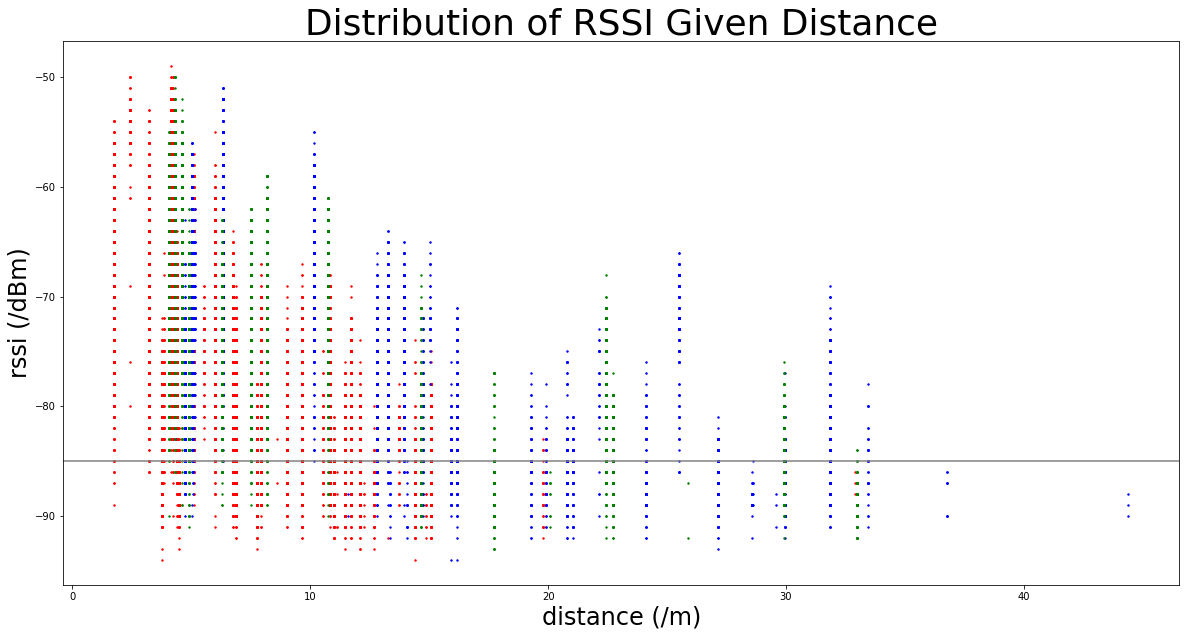

In [122]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(20,10))
ax.axis('auto')
ax.set_title('Distribution of RSSI Given Distance', fontsize=36)
ax.set_xlabel('distance (/m)', fontsize=24)
ax.set_ylabel('rssi (/dBm)', fontsize=24)
ax.scatter(data_8F.dist.values, data_8F.rssi.values, s=2, c='red')
ax.scatter(data_G.dist.values, data_G.rssi.values, s=2, c='blue')
ax.scatter(data_LG.dist.values, data_LG.rssi.values, s=2, c='green')
ax.axhline(y=-85, c='grey')
plt.savefig('dist_RSSI.png')
plt.show()

In [135]:
data_beacon = pd.read_csv('survey/0621/beacon.csv', usecols=[0,1,2])
data_beacon.columns = ('bID', 'rssi', 'ts')
data_8F = pd.concat(data_beacon[(data_beacon.ts >= interval[0]) & (data_beacon.ts < interval[1]) & data_beacon.bID.isin(beacon_loc_8F.index)] for interval in gt_ct_8F)



[1.65580156e+09 1.65580156e+09 1.65580156e+09 ... 1.65580262e+09
 1.65580262e+09 1.65580262e+09]
